# **DIP assignment 2**
- - - - 


In [2]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import math
from math import exp,sqrt
import time

## *Question 1*

- $m(x,y) = f(x,y) - fb(x,y)\ \ \ $    edge detection
- $g(x,y) = f(x,y) + p*m(x,y) \ \ \   $ high boosting edge
- $g(x,y) = (p+1)*f(x,y) -p*fb(x,y)$

In [2]:
def gaussian_Kernel(size, sigma=1, twoDimensional=True):
    if twoDimensional:
        kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    else:
        kernel = np.fromfunction(lambda x: math.e ** ((-1*(x-(size-1)/2)**2) / (2*sigma**2)), (size,))
    return kernel / np.sum(kernel)

In [3]:
def gaussKernelGenerator(size,sigma=1):
    kernel = gaussian_Kernel(size,sigma,True)
    return np.std(kernel),kernel

In [123]:
img1 = cv2.cvtColor(cv2.imread('./../images/webb.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('./../images/webb.jpg'), cv2.COLOR_BGR2RGB)
sigma =1
p= 3

In [221]:
def conv_transform(image):
    image_copy=image.copy()
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_copy[i][j]=image[image.shape[0]-i-1][image.shape[1]-j-1]
    return image_copy

In [222]:
def conv(image, kernel):
    kernel=conv_transform(kernel)
    image_h=image.shape[0]
    image_w=image.shape[1]
    
    kernel_h=kernel.shape[0]
    kernel_w=kernel.shape[1]
    
    h=kernel_h//2
    w=kernel_w//2
    
    image_conv=np.zeros(image.shape)
    
    for i in range(h, image_h-h):
        for j in range(w, image_w-w):
            sum=0
            
            for m in range(kernel_h):
                for n in range(kernel_w):
                    sum=sum+kernel[m][n]*image[i-h+m][j-w+n]
                    
            image_conv[i][j]=sum
            
    return image_conv

In [5]:
def convolve(img,kernel):
    k_size=kernel.shape
    i_size=img.shape
    img1=np.zeros((i_size[0],i_size[1]))
    image_padded = np.zeros((i_size[0] + k_size[0], i_size[1] + k_size[0]))   
    image_padded[int(k_size[0]/2):-1*int(k_size[0]/2)-1, int(k_size[0]/2):-1*int(k_size[0]/2)-1] = img
    for i in range(i_size[0]):
        for j in range(i_size[1]):
            temp=np.multiply(kernel,image_padded[i:i+k_size[0],j:j+k_size[0]])
            img1[i,j]=temp.sum()
    
    #Normalizing output
    img1=img1/kernel.sum()
    img1=np.round(img1)    
    img1=np.clip(img1,0,255)        
    return img1
    

In [6]:
def convolve_colour(img,kernel):
    img1=img.copy()
    img1[:,:,0]=convolve(img[:,:,0],kernel)
    img1[:,:,1]=convolve(img[:,:,1],kernel)
    img1[:,:,2]=convolve(img[:,:,2],kernel)
    
    return img1
    

In [7]:
def applyFilter(img, filter):
  # Padding image
  maxVal = max(filter.shape)
  img3 = np.zeros((img.shape[0] + 2 * maxVal, img.shape[1] + 2 * maxVal))
  img3[maxVal:img3.shape[0] - maxVal, maxVal:img3.shape[1] - maxVal] = img
  img3 = img3.astype('float')
  filter = filter.astype('float')
  img2 = img3.copy()
  # Convolution
  for r in range(filter.shape[0], img2.shape[0] - filter.shape[0] + 1):
    for c in range(filter.shape[1], img2.shape[1] - filter.shape[1] + 1):
      img2[r][c] = np.sum(img3[r - int(filter.shape[0] / 2):r - int(filter.shape[0] / 2) + filter.shape[0], c - int(filter.shape[1] / 2):c - int(filter.shape[1] / 2) + filter.shape[1]] * filter)
  # Remove padded region and return image
  return img2[maxVal:img2.shape[0] - maxVal, maxVal:img2.shape[1] - maxVal]

In [65]:
def unsharpmasking(img,window_size):
    half=int(window_size/2)
    ##Creating all pass filter with the given weight factor
    ##Creating high pass filter will all center element of kernel as window size -1 and rest all elements as -1
    w_high_pass=np.ones((window_size,window_size))
    w_high_pass=w_high_pass*(-1);
    w_high_pass[half][half]=(window_size)**2-1

    lap =  applyFilter(img, w_high_pass)
   

# Calculate the sharpened image
    sharp = img + lap
       
    sharp[sharp>255] = 255
    sharp[sharp<0] = 0
    
    #Convolving with corresponding high boost kernel gives required output
    return sharp
    

In [114]:
def high(img,window_size,p):

    kernel = gaussian_Kernel(window_size, sigma=1, twoDimensional=True)
    blur = applyFilter(img, kernel)
    rep = p*(img - blur)
    high = img+rep
       
    high[high>255] = 255
    high[high<0] = 0
    #Convolving with corresponding high boost kernel gives required output
    return high

Text(0.5, 1.0, 'highboost with weight=5 and window size=3')

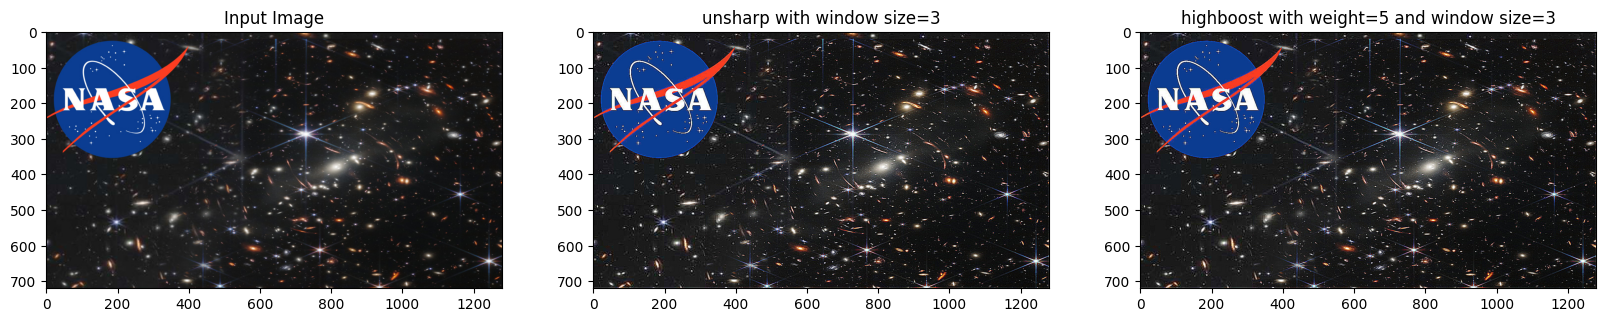

In [124]:
original_image = img1
window =3
sharp1 = np.zeros_like(original_image)
for i in range(3):
    sharp1[:,:,i] = unsharpmasking(original_image[:,:,i],window)

img2 = np.zeros_like(original_image)
for i in range(3):
    img2[:,:,i] = high(original_image[:,:,i],window,10)
#img2 = highboostfiltering(img1,3,5) 
fig = plt.figure(figsize=[20, 20])
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.title("Input Image")
plt.subplot(1,3,2)
plt.imshow(sharp1.astype('uint8'))
plt.title("unsharp with window size=3")
plt.subplot(1,3,3)
plt.imshow(img2)
plt.title("highboost with weight=10 and window size=3")

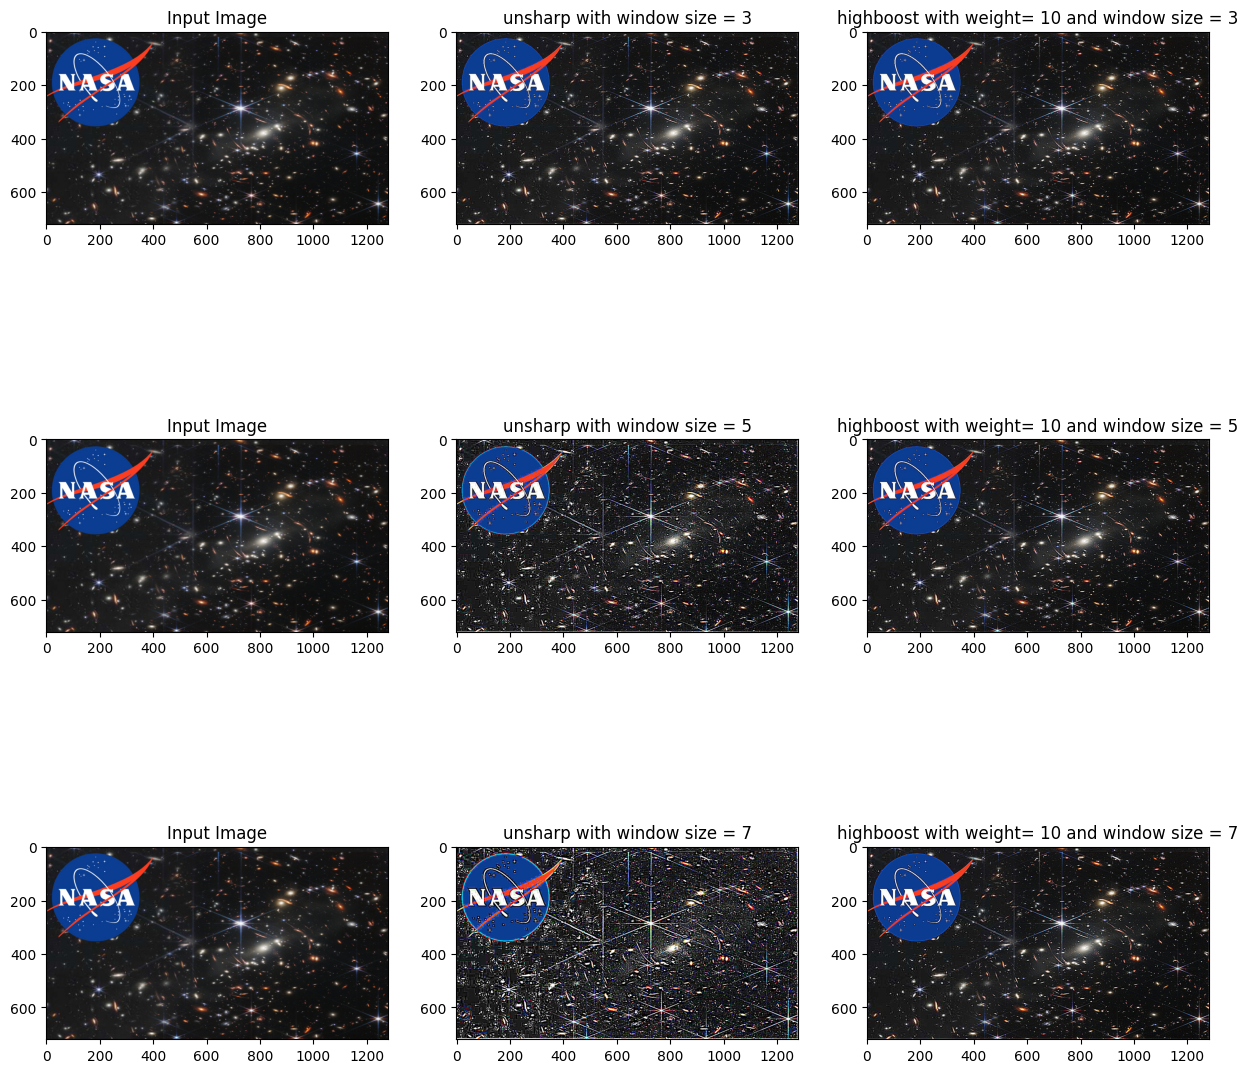

In [126]:
img=cv2.imread('./../images/webb.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
unsharp_arr = []
highboost_arr = []
weight =10
k = [3,5,7]
fig, axs = plt.subplots(3,3,figsize=(15,15))
for i in k:
    s1 = time.time()
    op1 = np.zeros_like(img)
    for j in range(3):
        op1[:,:,j] = high(img[:,:,j],i,weight)
    e1 = time.time()
    
    highboost_arr.append(e1-s1)
    
    s2 = time.time()
    
    sharp1 = np.zeros_like(img)
    
    for j in range(3):
        sharp1[:,:,j] = unsharpmasking(img[:,:,j],i)
        
    p = int((i-3)/2)
    e2 = time.time()
    unsharp_arr.append(e2-s2)
    axs[p][0].imshow(img,cmap='gray')
    axs[p][0].title.set_text("Input Image")
    axs[p][1].imshow(sharp1.astype('uint8'))
    axs[p][1].title.set_text("unsharp with window size = "+str(i))
    axs[p][2].imshow(op1.astype('uint8'))
    axs[p][2].title.set_text("highboost with weight= "+ str(weight)+ " and window size = "+str(i))

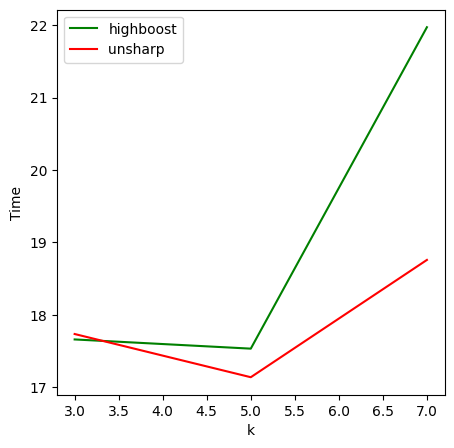

In [127]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(k, highboost_arr, 'g', label='highboost')
plt.plot(k, unsharp_arr, 'r', label='unsharp ')
plt.xlabel("k")
plt.ylabel("Time")
plt.legend()
plt.show()

*Observations* - we see that highboost filter is better than unsharp filter in terms of image quality and sharpening and we know that as we increase window size the sharpening also increases.

In [3]:
def bilateralFilterMine(im,d,sigma_d,sigma_r):
    print(im.shape)
    r=im.shape[0]
    c=im.shape[1]
    d2 = d//2
    pad = d-1
    im = cv2.copyMakeBorder(im, pad, pad, pad, pad, cv2.BORDER_CONSTANT,0)

    final=np.zeros((r,c))
    new = np.ones((d,d))
    for i in range(d-1,r-d+1):
        for j in range(d-1,c-d+1):
            for m in range(d):
                for n in range(d):
                    im_part=im[i:i+d,j:j+d]
                    k1 = exp((-1/(2*sigma_d*sigma_d))*((m-d2)**2+(n-d2)**2))
                    k2 = exp((-1/(2*sigma_r*sigma_r))*((im_part[m,n]-im_part[d2,d2])**2))
                    new[m,n] = k1*k2
            sumArr = np.sum(new)
            new=new/sumArr
            final[i,j] = np.sum(np.multiply(im_part,new))
        
    return final

(388, 291)


/tmp/ipykernel_76896/257457969.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
  k2 = exp((-1/(2*sigma_r*sigma_r))*((im_part[m,n]-im_part[d2,d2])**2))


(388, 291)
(388, 291)
(388, 291)


KeyboardInterrupt: 

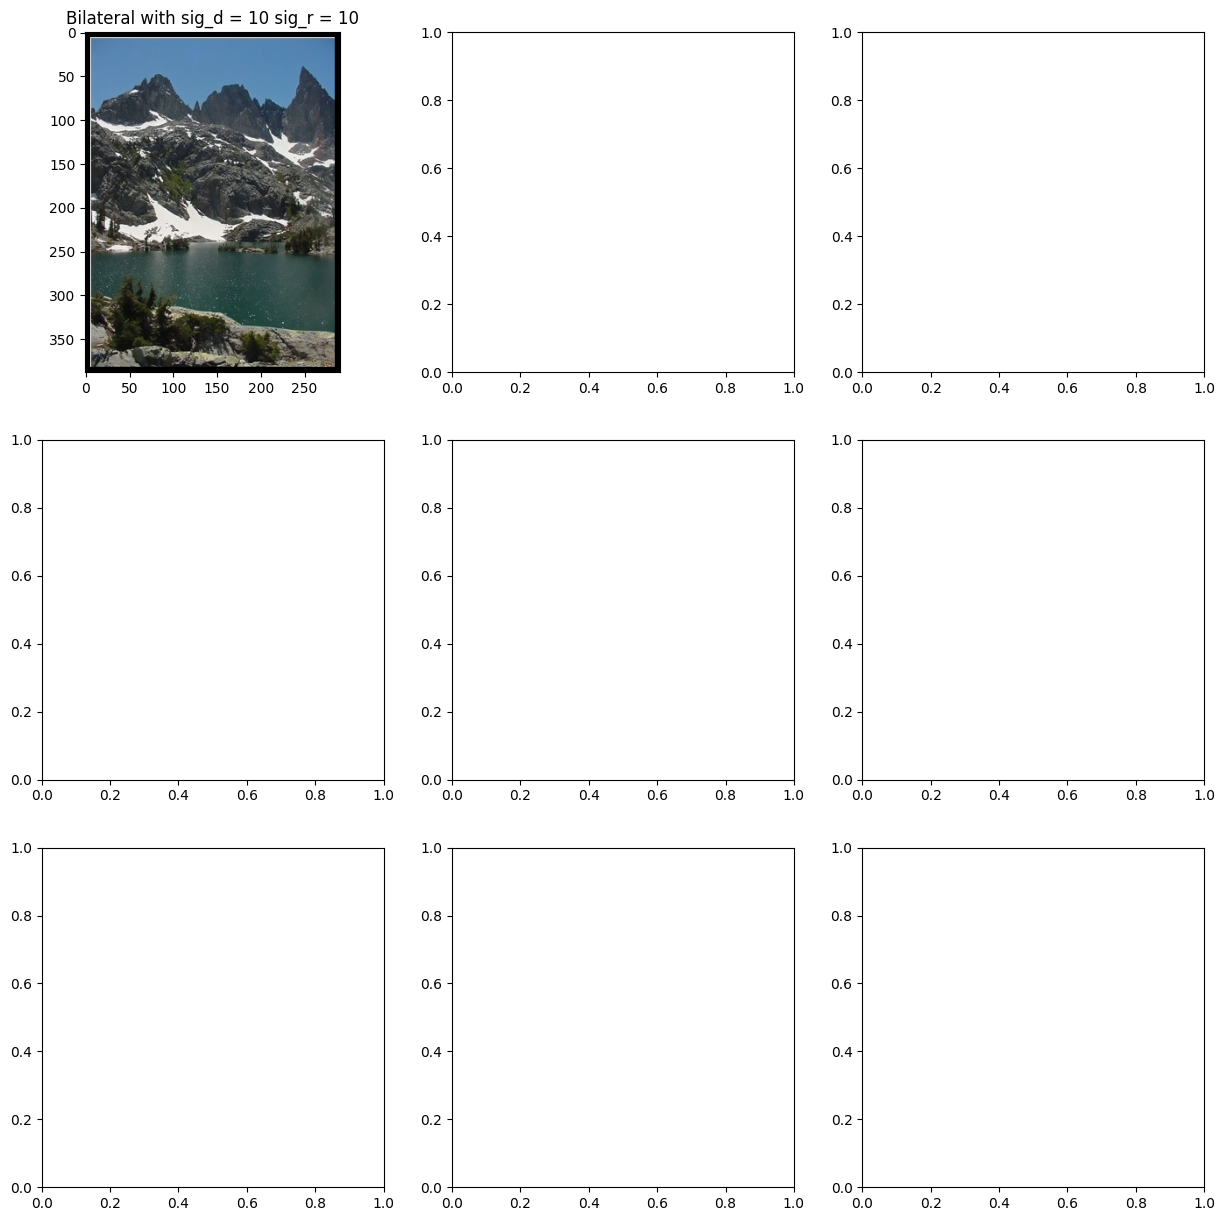

In [4]:
img1 = cv2.cvtColor(cv2.imread('./../images/lakeside.jpg'), cv2.COLOR_BGR2RGB)
sky1 = cv2.bilateralFilter(img1,40,40,80,80)


diameter = 7
sharp1 = np.zeros_like(img1)
fig, axs = plt.subplots(3,3,figsize=(15,15))
for i in range(10,51,20):
    for j in range(10,51,20):
        for k in range(3):
          sharp1[:,:,k] = bilateralFilterMine(img1[:,:,k],diameter,i,j)
        p = int((i-10)/20)
        q = int((j-10)/20)
        axs[p][q].imshow(sharp1)
        axs[p][q].title.set_text("Bilateral with sig_d = "+str(i)+" sig_r = "+str(j))





*Observations*

 - As the range parameter $\sigma_{r}$ increases, the bilateral filter gradually approaches Gaussian convolution more closely because the range Gaussian widens and flattens, which means that it becomes nearly constant over the intensity interval of the image.


- As the spatial parameter $\sigma_{d}$ increases, the larger features get smoothened

(380, 606)


/tmp/ipykernel_76389/257457969.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
  k2 = exp((-1/(2*sigma_r*sigma_r))*((im_part[m,n]-im_part[d2,d2])**2))


(380, 606)
(380, 606)


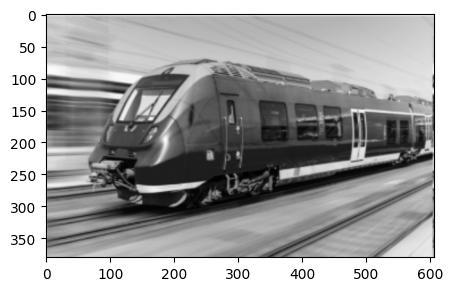

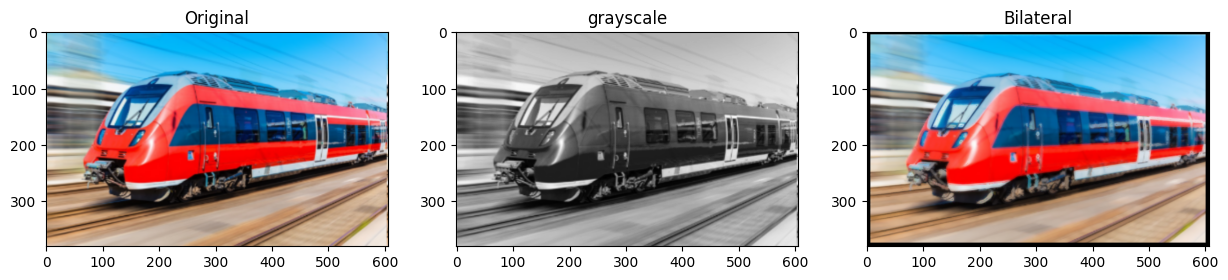

In [129]:
BLACK = 0
WHITE = 255


img1 = cv2.cvtColor(cv2.imread('./../images/cartoon.jpg'), cv2.COLOR_BGR2RGB)
original_image = img1
bilateralImg = np.zeros_like(original_image)
for i in range(3):
    bilateralImg[:,:,i] = bilateralFilterMine(img1[:,:,i],7,60,60)
    
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

fig, axs = plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.title("Original")
plt.subplot(1,3,2)
plt.imshow(gray,'gray')
plt.title("grayscale")
plt.subplot(1,3,3)
plt.imshow(bilateralImg)
plt.title("Bilateral")
plt.show()

In [203]:
def average(img, k):
    output = np.zeros_like(img)
    m = math.floor(float(k)/2)

    image_padded = np.zeros((img.shape[0] + 2*m, img.shape[1] + 2*m))   
    image_padded[m:-m, m:-m] = img

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = (image_padded[i:i+k,j:j+k]).sum()
            output[i,j] = val/(k*k)
            
    
    return output

In [202]:
def average_eff(img, k):
    x, y = img.shape
    arr = np.cumsum(np.cumsum(img, axis = 0), axis = 1)
    
    a = arr[k-1:x,k-1:y]
    b = arr[k-1:x,0:y-k+1]
    c = arr[0:x-k+1,k-1:y]
    d = arr[0:x-k+1,0:y-k+1]
    
    output = a + d - b - c
    
    return output

In [208]:
def adaptive_mean_thresholding(grayscale_image, radius):
    bw_image = np.zeros_like(grayscale_image)
    max_row, max_col = grayscale_image.shape
    for i, row in enumerate((grayscale_image)):
        y_min = max(0, i - radius)
        y_max = min(max_row, i + radius + 1)
        for j, elem in enumerate(row):
            x_min = max(0, j - radius)
            x_max = min(max_col, j + radius + 1)
            window = grayscale_image[y_min:y_max, x_min:x_max]
            if grayscale_image[i, j] >= (np.mean(window)+3):
                bw_image[i, j] = BLACK
            else :
                 bw_image[i, j] = WHITE
    return bw_image

In [224]:
img1 = cv2.imread('./../images/cartoon.jpg',0)
k = [3,5,7,9] # similarly in a loop we can resize the images and run a loop to compute time in each image 
arr_average = []
arr_eff_average = []
gaussian =[]

for k_val in k:
    s1 = time.time()
    img2 = average(img1, k_val)
    e1 = time.time()
    t1 = e1 - s1
    arr_average.append(t1)

    s2 = time.time()
    img3 = average_eff(img1, k_val)
    e2 = time.time()
    t2 = e2 - s2
    arr_eff_average.append(t2)
    
    s3 = time.time()
    img4 = conv(img1,gaussian_Kernel(k_val))
    e3 = time.time()
    t3 = e3 - s3
    gaussian.append(t3)

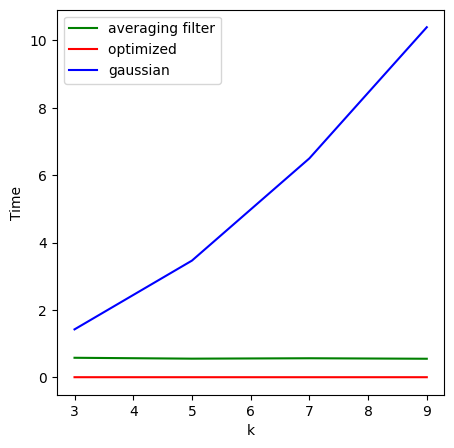

In [225]:
plt.plot(k, arr_average, 'g', label='averaging filter')
plt.plot(k, arr_eff_average, 'r', label='optimized ')
plt.plot(k, gaussian, 'b', label='gaussian')
plt.xlabel("k")
plt.ylabel("Time")
plt.legend()
plt.show()

*observations* we see that optimized mean is best

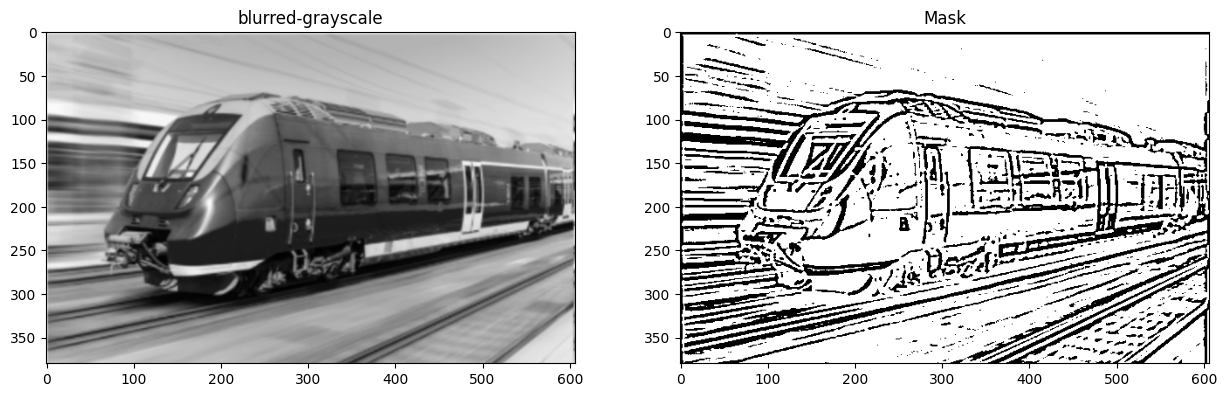

In [209]:

blur = average(gray,2)
median_bw = adaptive_mean_thresholding(blur, radius=3)

fig, axs = plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(blur,'gray')
plt.title("blurred-grayscale")
plt.subplot(1,2,2)
plt.imshow(median_bw,cmap='gray')
plt.title("Mask")
plt.show()


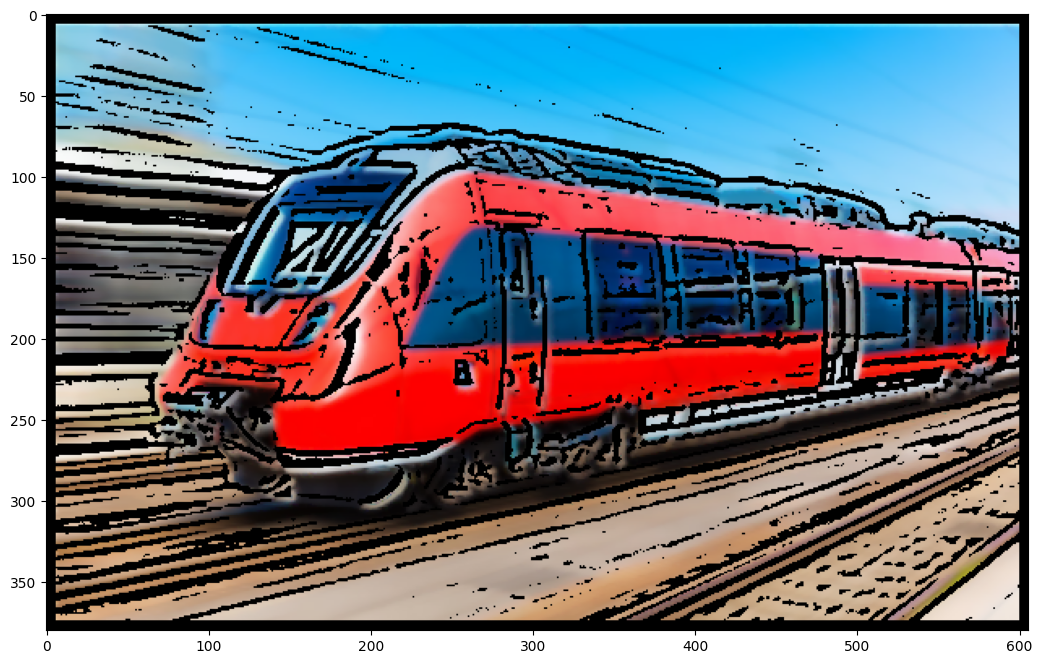

In [167]:
result = bilateralImg & np.dstack((median_bw, median_bw, median_bw))

plt.figure(figsize=(15, 8))
plt.imshow(result)

In [197]:
def FFT1D(x):
    length = len(x)
    if length <= 1: return x
    even = FFT1D(x[0::2])
    odd =  FFT1D(x[1::2])
    T= [np.exp(-2j*np.pi*k/length)*odd[k] for k in range(len(odd))]
    return [even[k] + T[k] for k in range(len(even))] + \
           [even[k] - T[k] for k in range(len(even))]

In [198]:
def FFT2(img):
    img = np.apply_along_axis(FFT1D,1,img)
    return np.apply_along_axis(FFT1D,0,img)

In [220]:
def DFT2(padded):
    M,N = np.shape(padded)
    dft2d = np.zeros((M,N),dtype=complex)
    for k in range(M):
        for l in range(N):
            sum_matrix = 0
            for m in range(M):
                for n in range(N):
                    e = np.exp(- 2j * np.pi * ((k * m) / M + (l * n) / N))
                    sum_matrix +=  padded[m,n] * e
            dft2d[k,l] = sum_matrix
    return dft2d

In [219]:
def IFFT(F):
    transform = F

    imageWidth = transform.shape[1] #Saves the number of horizontal pixels to imageWidth (M)
    imageHeight = transform.shape[0] #Saves the number of vertical pixels to imageHeight (N)

    #The complex conjugate is taken of transformed image, followed by the dft2, and then the real component of the complex conjugate
    conj_transform = np.conjugate(transform)
    conj_g = DFT2(conj_transform)
    g = np.real(np.conjugate(conj_g))

   
    g = 255*(g/(imageWidth*imageHeight))

    return g

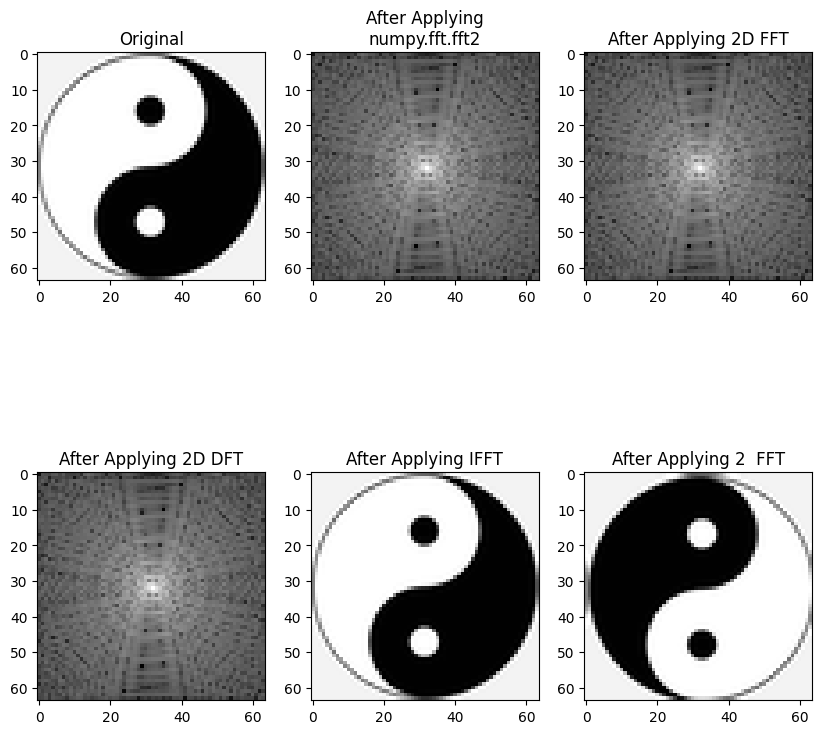

In [232]:
fftImgInput = cv2.imread('./../images/yang.png', 0)

numpyFFT = np.fft.fft2(fftImgInput)
dftImg = DFT2(fftImgInput)
fftImg = FFT2(fftImgInput)
ifftImg = IFFT(fftImg)
fftfftImg = FFT2(fftImg)
# Plotting
f, axarr = plt.subplots(2, 3, figsize=(10,10))
axarr[0][0].imshow(fftImgInput, cmap='gray')
axarr[0][0].title.set_text('Original',)
axarr[0][1].imshow(np.log(1 + np.abs(np.fft.fftshift(numpyFFT))), cmap='gray')
axarr[0][1].title.set_text('After Applying\nnumpy.fft.fft2',)
axarr[0][2].imshow(np.log(1 + np.abs(np.fft.fftshift(fftImg))), cmap='gray')
axarr[0][2].title.set_text('After Applying 2D FFT',)
axarr[1][0].imshow(np.log(1 + np.abs(np.fft.fftshift(dftImg))), cmap='gray')
axarr[1][0].title.set_text('After Applying 2D DFT',)
axarr[1][1].imshow(np.abs(ifftImg),cmap='gray')
axarr[1][1].title.set_text('After Applying IFFT',)
axarr[1][2].imshow(np.abs(fftfftImg), cmap='gray')
axarr[1][2].title.set_text('After Applying 2  FFT',)

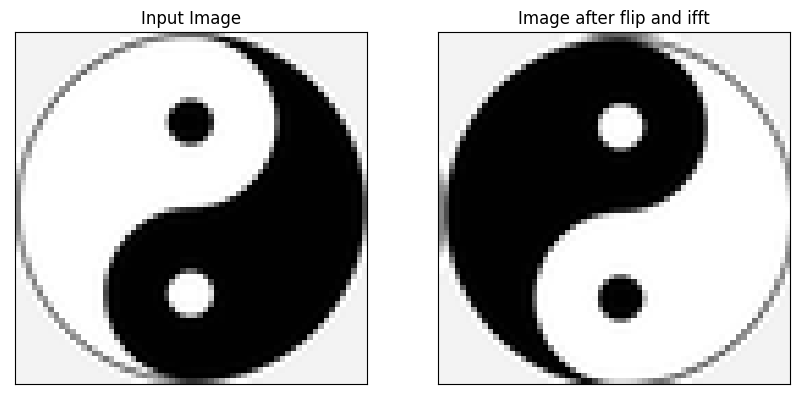

In [7]:
img = fftImgInput

fftImg = np.flip(fftImg, axis=(0, 1))

img_back = np.fft.ifft2(fftImg)
img_back = np.abs(img_back)
plt.rcParams['figure.figsize'] = (10,10)
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after flip and ifft'), plt.xticks([]), plt.yticks([])

plt.show()

We can observe that the image is the same but has been reversed in the x and the y directions. To fix this at the frequency domain level, we will flip the first FFT matrix which we get, about the x and y axis and then find the FFT of this new flipped matrix.

In [8]:
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[1])**2 + (point1[1]-point2[1])**2)

In [9]:
def gaussLP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows,cols = imgShape[:2]
    center = (int(rows/2),int(cols/2))
    for x in range(cols):
        for y in range(rows):
            base[y,x] = np.exp(((-(distance((y,x),(int(rows/2),int(cols/2)))**2))/(2*(D0**2))))
    return base

In [10]:
def FilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows,cols = imgShape[:2]
    center = (int(rows/2),int(cols/2))
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

In [11]:
def LPFilter( size,img):
  U, V = np.shape(img)
  filter = np.zeros(img.shape)
  sqrtArr = filter.copy()

  # Precomputing distance between u and v
  for u in range(U):
    for v in range(V):
      sqrtArr[u, v] = np.sqrt(u**2 + v**2)

  # Assigning values to filter
  for u in range(U):
    for v in range(V):        
      filter[u, v] = (sqrtArr[np.abs(u - (U // 2)), np.abs(v - (V // 2))] <= size)

  return filter

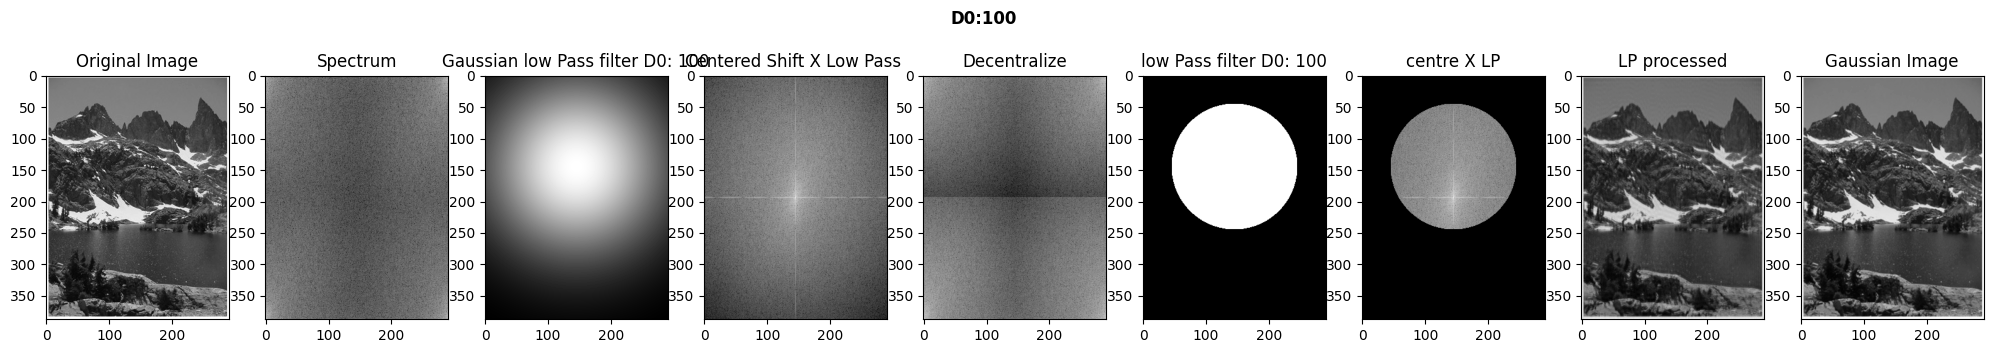

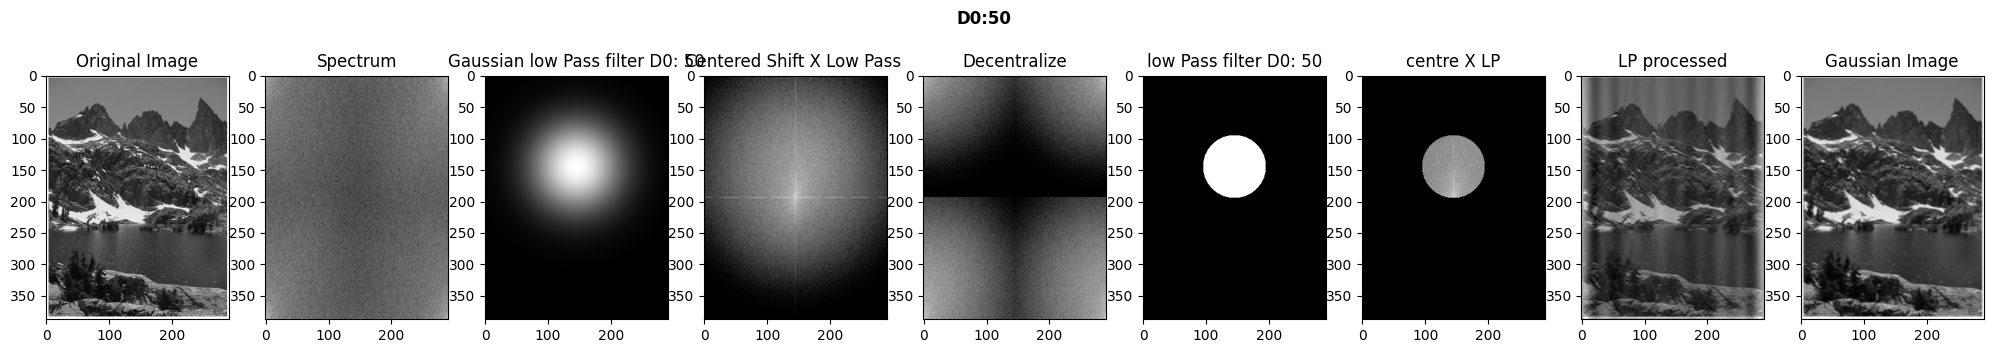

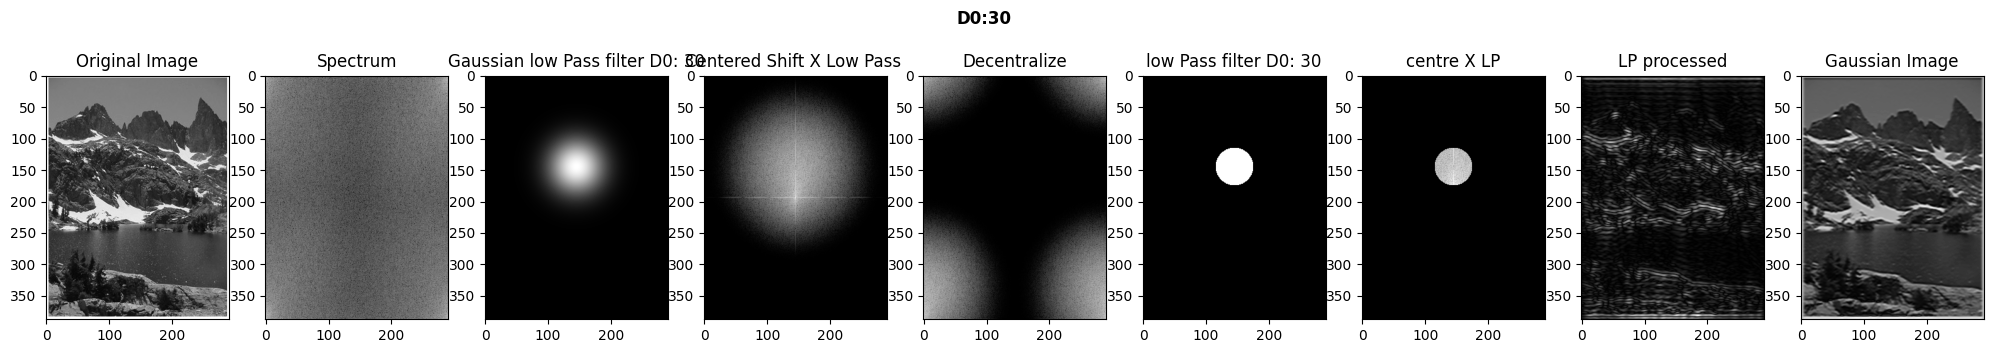

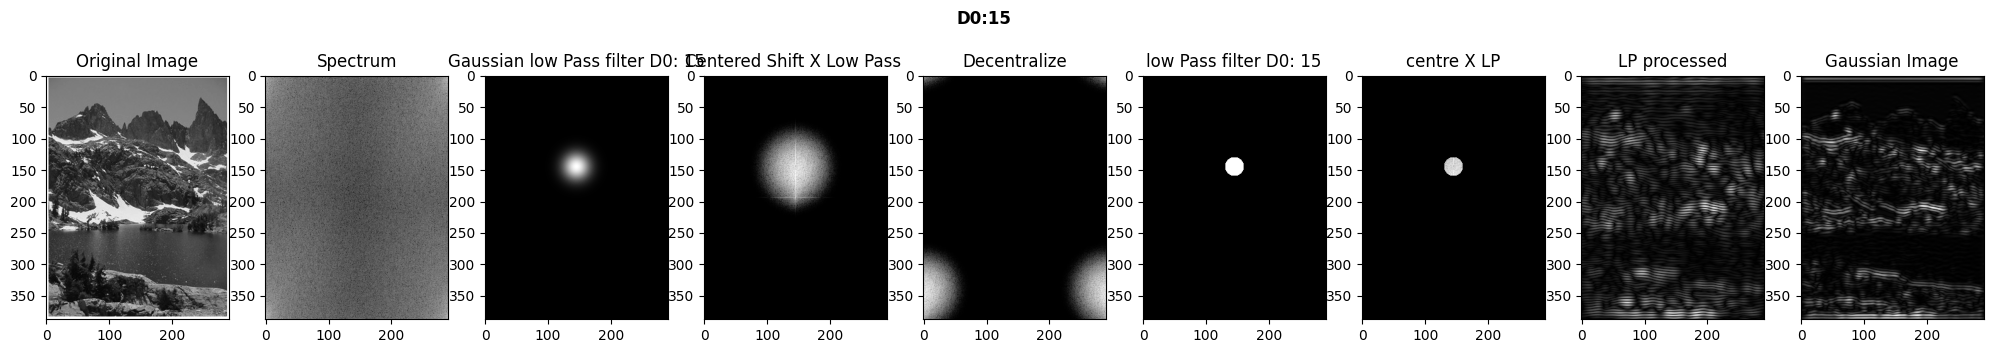

In [12]:
img = cv2.imread('./../images/lakeside.jpg',0)


def try_d0s_lp(d0):
    plt.figure(figsize=(25, 5), constrained_layout=False)

    plt.subplot(191), plt.imshow(img, "gray"), plt.title("Original Image")

    original = DFT2(img)
    plt.subplot(192), plt.imshow(np.log(1+np.abs(original)), "gray"), plt.title("Spectrum")

    center = np.fft.fftshift(original)
   # plt.subplot(193), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Center shifted")
    plt.subplot(193),plt.imshow(gaussLP(d0,img.shape),cmap="gray") ,  plt.title("Gaussian low Pass filter D0: "+str(i))
    
 
    LowPassCenter = center * gaussLP(d0,img.shape)
    plt.subplot(194), plt.imshow(np.log(1+np.abs(LowPassCenter)), "gray"), plt.title("Centered Shift X Low Pass ")

    LowPass = np.fft.ifftshift(LowPassCenter)
    plt.subplot(195), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralize")
    
    H = FilterLP( d0,center.shape)
    plt.subplot(196),plt.imshow(H,cmap="gray") ,  plt.title("low Pass filter D0: "+str(i))
    
    fftImgNew = center * H
    plt.subplot(197),plt.imshow(np.log(1+np.abs(fftImgNew)),cmap="gray") ,  plt.title("centre X LP")
   
    fftImgNew = np.fft.ifftshift(fftImgNew)
                                
    lpfinal = IFFT(fftImgNew)
    plt.subplot(198),plt.imshow(np.abs(lpfinal), cmap='gray') ,  plt.title("LP processed")
        
    inverse_LowPass = IFFT(LowPass)
    plt.subplot(199), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Gaussian Image")

    plt.suptitle("D0:"+str(d0),fontweight="bold")
    plt.subplots_adjust(top=1.1)
    plt.show()
    
for i in [100,50,30,15]:
    try_d0s_lp(i)
   

*Observations* -

- ideal low pass filter gives ringing effect 
- gaussian filter does not give ringing effect

(<AxesSubplot:title={'center':'Gaussian Image'}>,
 Text(0.5, 1.0, 'Gaussian Image'))

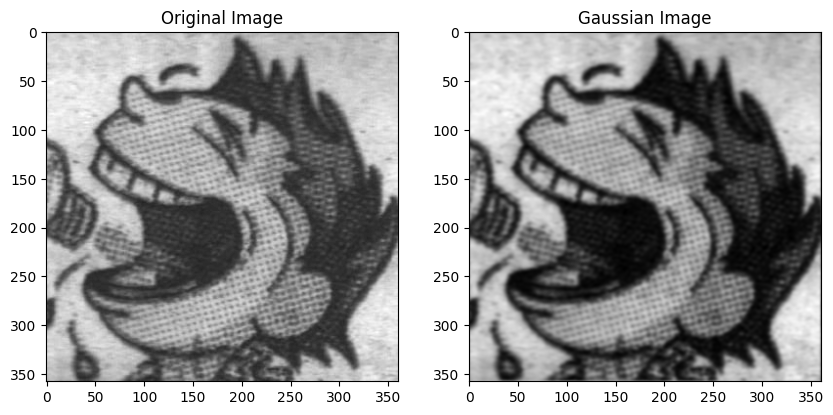

In [13]:
img =cv2.imread('./../images/cart.jpg',0)

original = DFT2(img)
center = np.fft.fftshift(original)
LowPassCenter = center * gaussLP(50,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)

plt.subplot(121), plt.imshow(img, "gray"), plt.title("Original Image")
inverse_LowPass = IFFT(LowPass)
plt.subplot(122), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Gaussian Image")
